In [1]:
!pip install -q wordninja pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Imports
!pip install -q transformers datasets evaluate scikit-learn pandas numpy matplotlib seaborn

import os
import re
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import wordninja
from datasets import Dataset
from datetime import datetime
import torch
from torch.nn import CrossEntropyLoss

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, label_ranking_average_precision_score, accuracy_score, ConfusionMatrixDisplay
from transformers import RobertaTokenizerFast, TFRobertaModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
# from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [3]:
# Mount Google Driv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set output directory for results
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_dir = f"/content/drive/MyDrive/266_final_project_outputs/roberta_model_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

In [6]:
# Load Data
data_dir = "drive/MyDrive/266_final_project/data"

# Load .tsv files
train_data = pd.read_csv("drive/MyDrive/266_final_project/data/train.tsv", sep='	', header=None, names=['Text', 'Class', 'ID'])
valid_data = pd.read_csv("drive/MyDrive/266_final_project/data/dev.tsv", sep='	', header=None, names=['Text', 'Class', 'ID'])
test_data = pd.read_csv("drive/MyDrive/266_final_project/data/test.tsv", sep='	', header=None, names=['Text', 'Class', 'ID'])

# Load emotions list
with open(f"{data_dir}/emotions.txt", "r") as f:
    emotion_list = f.read().splitlines()

In [7]:
df_full = pd.read_csv("drive/MyDrive/266_final_project/outputs/goemotions_primary_label.csv")
df_full.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,primary_label
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,1,0,0,24
1,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,1,26
2,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,0,0,0,0,0,0,0,0,0,17
3,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,1,26
4,Right? Considering it’s such an important docu...,eespn2i,ImperialBoss,TrueReddit,t3_aizyuz,t1_eesoak0,1.548280e+09,61,False,0,...,0,0,0,0,0,0,0,0,0,14


In [8]:
# Keep only ID subreddit
full_meta = df_full[["id", "subreddit"]].drop_duplicates()

In [9]:
def clean_subreddit_name(subreddit):
    subreddit = subreddit.replace("_", " ")
    words = []
    for word in subreddit.split():
        words += wordninja.split(word)
    return " ".join(words)

def build_input_with_context(row):
    subreddit_clean = clean_subreddit_name(row["subreddit"])
    return f"subreddit {subreddit_clean}: {row['Text']}"

def merge_and_add_context(split_df):
    merged = split_df.merge(full_meta, how="left", left_on="ID", right_on="id")
    merged = merged.dropna(subset=["subreddit"])
    merged["text_with_context"] = merged.apply(build_input_with_context, axis=1)
    return merged

train_df = merge_and_add_context(train_data)
valid_df = merge_and_add_context(valid_data)
test_df  = merge_and_add_context(test_data)

train_df.head()

,Text,Class,ID,id,subreddit,text_with_context
0,My favourite food is anything I didn't have to...,27,eebbqej,eebbqej,KitchenConfidential,subreddit Kitchen Confidential: My favourite f...
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,ed00q6i,morbidquestions,subreddit morbid questions: Now if he does off...
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,eezlygj,timberwolves,subreddit timberwolves: WHY THE FUCK IS BAYLES...
3,To make her feel threatened,14,ed7ypvh,ed7ypvh,askwomenadvice,subreddit ask women advice: To make her feel t...
4,Dirty Southern Wankers,3,ed0bdzj,ed0bdzj,london,subreddit london: Dirty Southern Wankers


In [10]:
# Parse labels into lists of emotion names
def decode_labels(label_str):
    return [emotion_list[int(i)] for i in label_str.split(',')]

train_df['decoded'] = train_df['Class'].apply(decode_labels)
valid_df['decoded'] = valid_df['Class'].apply(decode_labels)
test_df['decoded'] = test_df['Class'].apply(decode_labels)

In [11]:
# Filter out 'neutral' and 'disgust'
EXCLUDED_LABELS = {'neutral', 'disgust'}

def filter_labels(row):
    return [e for e in row if e not in EXCLUDED_LABELS]

def remove_rows(df):
    df = df.copy()
    df['filtered'] = df['decoded'].apply(filter_labels)
    return df[df['filtered'].map(len) > 0]

train_df = remove_rows(train_df)
valid_df = remove_rows(valid_df)
test_df = remove_rows(test_df)

In [12]:
# Create new emotion set
ekman_labels_3 = sorted(list(set([e for row in train_df['filtered'] for e in row])))
label_to_idx = {label: i for i, label in enumerate(ekman_labels_3)}

In [13]:
def get_primary_from_filtered(filtered):
    if isinstance(filtered, list) and filtered:
        return label_to_idx[filtered[0]]
    return -1

# Assign primary label from first valid emotion
train_df['primary'] = train_df['filtered'].apply(get_primary_from_filtered)
valid_df['primary'] = valid_df['filtered'].apply(get_primary_from_filtered)
test_df['primary']  = test_df['filtered'].apply(get_primary_from_filtered)

# Drop rows with no valid primary label
train_df = train_df[train_df['primary'] != -1]
valid_df = valid_df[valid_df['primary'] != -1]
test_df  = test_df[test_df['primary'] != -1]

In [ ]:
# # Oversample underrepresented classes in training set
# def oversample_minority_classes(df, target_col, target_ratio=0.5):
#     counts = df[target_col].value_counts()
#     max_count = counts.max()
#     frames = [df]
#     for label, count in counts.items():
#         if count / max_count < target_ratio:
#             multiplier = int((target_ratio * max_count) // count)
#             df_min = df[df[target_col] == label]
#             frames.append(pd.concat([df_min] * multiplier, ignore_index=True))
#     return pd.concat(frames, ignore_index=True)

# train_df = oversample_minority_classes(train_df, "primary", target_ratio=0.35)

### Tokenization:

In [14]:
max_len = 128
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=max_len)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [15]:
# Add special tokens before tokenizing or training
special_tokens = {'additional_special_tokens': ['[SUBREDDIT:']}
tokenizer.add_special_tokens(special_tokens)
print(tokenizer.additional_special_tokens)

['[SUBREDDIT:']


In [16]:
# # Compute class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df['primary']),
#     y=train_df['primary']
# )

# # Convert to PyTorch tensor
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [17]:
# Create Dataset from train_df
train_ds = Dataset.from_pandas(train_df[['text_with_context', 'primary']].copy())

# Rename columns
train_ds = train_ds.rename_column("text_with_context", "text")
train_ds = train_ds.rename_column("primary", "labels")

# Tokenize and format for model
train_ds = train_ds.map(tokenize, batched=True)
train_ds = train_ds.with_format("torch")

Map:   0%|          | 0/29542 [00:00<?, ? examples/s]

In [18]:
val_ds = Dataset.from_pandas(valid_df[['text_with_context', 'primary']].copy())
val_ds = val_ds.rename_column("text_with_context", "text")
val_ds = val_ds.rename_column("primary", "labels")
val_ds = val_ds.map(tokenize, batched=True)
val_ds = val_ds.with_format("torch")

Map:   0%|          | 0/3712 [00:00<?, ? examples/s]

In [19]:
test_ds = Dataset.from_pandas(test_df[['text_with_context', 'primary']].copy())
test_ds = test_ds.rename_column("text_with_context", "text")
test_ds = test_ds.rename_column("primary", "labels")
test_ds = test_ds.map(tokenize, batched=True)
test_ds = test_ds.with_format("torch")

Map:   0%|          | 0/3670 [00:00<?, ? examples/s]

In [20]:
num_labels = len(label_to_idx)
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_labels
)

for param in model.parameters():
    param.requires_grad = True

# Resize token embeddings
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50266, 768, padding_idx=1)

In [21]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    run_name="roberta_no_weights_run",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    logging_strategy="epoch"
)

In [23]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [24]:
# class WeightedLossTrainer(Trainer):
#     def __init__(self, *args, class_weights=None, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights = class_weights

#     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
#         labels = inputs.get("labels")
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
#         loss = loss_fct(logits, labels)
#         return (loss, outputs) if return_outputs else loss

In [25]:
# trainer = WeightedLossTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     compute_metrics=compute_metrics,
#     class_weights=class_weights_tensor,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
# )

# trainer.train()

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[]
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.692600,1.435375,0.578125
2,1.283700,1.335968,0.599138
3,1.018400,1.334890,0.603448
4,0.759300,1.402963,0.607489
5,0.539900,1.505195,0.601293
6,0.431800,1.544071,0.598060


TrainOutput(global_step=11082, training_loss=0.9542732617416616, metrics={'train_runtime': 4451.16, 'train_samples_per_second': 39.822, 'train_steps_per_second': 2.49, 'total_flos': 1.1661752602884096e+16, 'train_loss': 0.9542732617416616, 'epoch': 6.0})

In [27]:
BEST_DIR = "/content/drive/MyDrive/266_final_project/best_model"

# Save to Drive
trainer.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)

('/content/drive/MyDrive/266_final_project/best_model/tokenizer_config.json',
 '/content/drive/MyDrive/266_final_project/best_model/special_tokens_map.json',
 '/content/drive/MyDrive/266_final_project/best_model/vocab.json',
 '/content/drive/MyDrive/266_final_project/best_model/merges.txt',
 '/content/drive/MyDrive/266_final_project/best_model/added_tokens.json',
 '/content/drive/MyDrive/266_final_project/best_model/tokenizer.json')

In [28]:
# Evaluate the model on validation or test set
eval_metrics = trainer.evaluate()

# Save metrics to Drive
with open(f"{BEST_DIR}/eval_metrics_subreddit.json", "w") as f:
    json.dump(eval_metrics, f, indent=2)

In [29]:
# Get predictions on test set
preds = trainer.predict(test_ds)

y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Reverse label_to_idx to get string label names
idx_to_label = {v: k for k, v in label_to_idx.items()}
label_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)

# Save full classification report
df_report.to_csv(f"{BEST_DIR}/emotion_classification_report_subreddit.csv")

df_emotions = df_report.loc[label_names][["precision", "recall", "f1-score"]]
df_report

,precision,recall,f1-score,support
admiration,0.67,0.75,0.71,430.0
amusement,0.82,0.88,0.85,252.0
anger,0.55,0.60,0.58,197.0
annoyance,0.44,0.37,0.40,286.0
approval,0.49,0.57,0.52,318.0
caring,0.48,0.45,0.46,114.0
confusion,0.60,0.49,0.54,139.0
curiosity,0.59,0.75,0.66,233.0
desire,0.68,0.41,0.51,74.0
disappointment,0.43,0.28,0.34,127.0


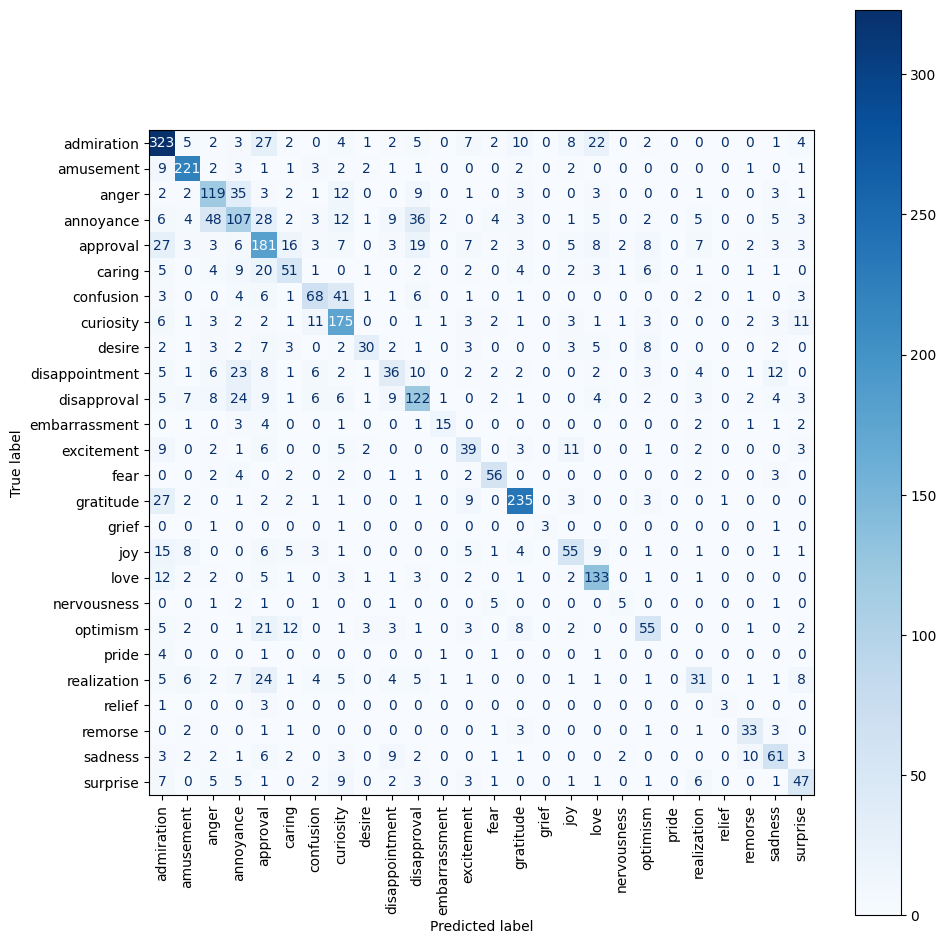

In [30]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Save matrix as image
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/confusion_matrix_subreddit.png")

# Save matrix as CSV
pd.DataFrame(cm, index=label_names, columns=label_names).to_csv(f"{BEST_DIR}/confusion_matrix_subreddit.csv")

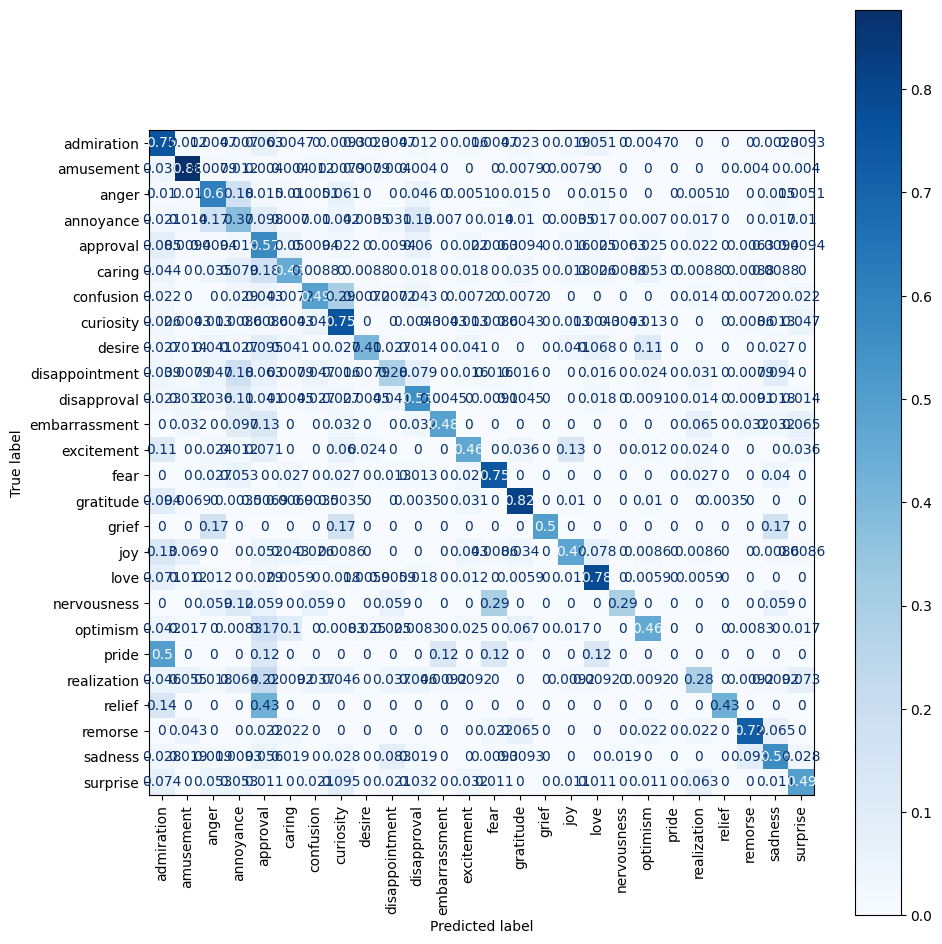

In [31]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Save matrix as image
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/confusion_matrix_normalized_subreddit.png")

# Save matrix as CSV
pd.DataFrame(cm_normalized, index=label_names, columns=label_names).to_csv(f"{BEST_DIR}/confusion_matrix_normalized_subreddit.csv")

In [32]:
df_report = df_report.rename_axis("Emotion").reset_index()
df_emotions = df_report[~df_report["Emotion"].str.contains("avg|accuracy|std", case=False, na=False)].copy()

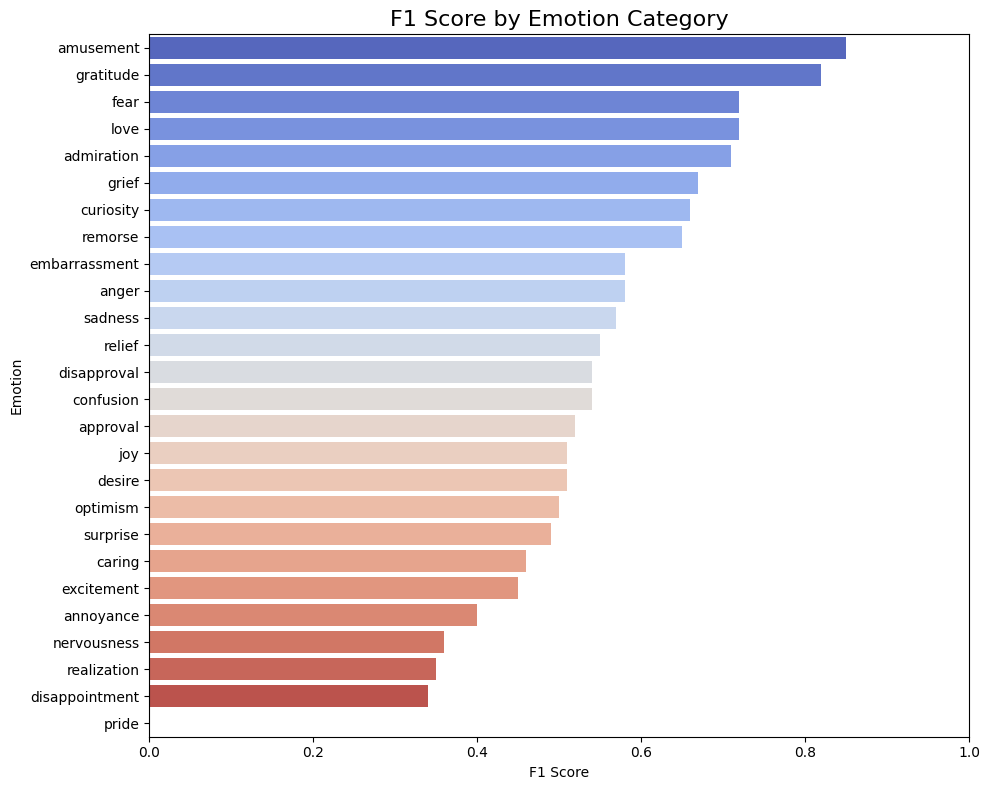

In [33]:
# Sort by F1
df_sorted = df_emotions.sort_values("f1-score", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_sorted, x="f1-score", y="Emotion", palette="coolwarm")
plt.title("F1 Score by Emotion Category", fontsize=16)
plt.xlabel("F1 Score")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/emotion_f1_scores_paper_style_subreddit.pdf")
plt.savefig(f"{BEST_DIR}/emotion_f1_scores_paper_styl_subreddit.png")
plt.show()

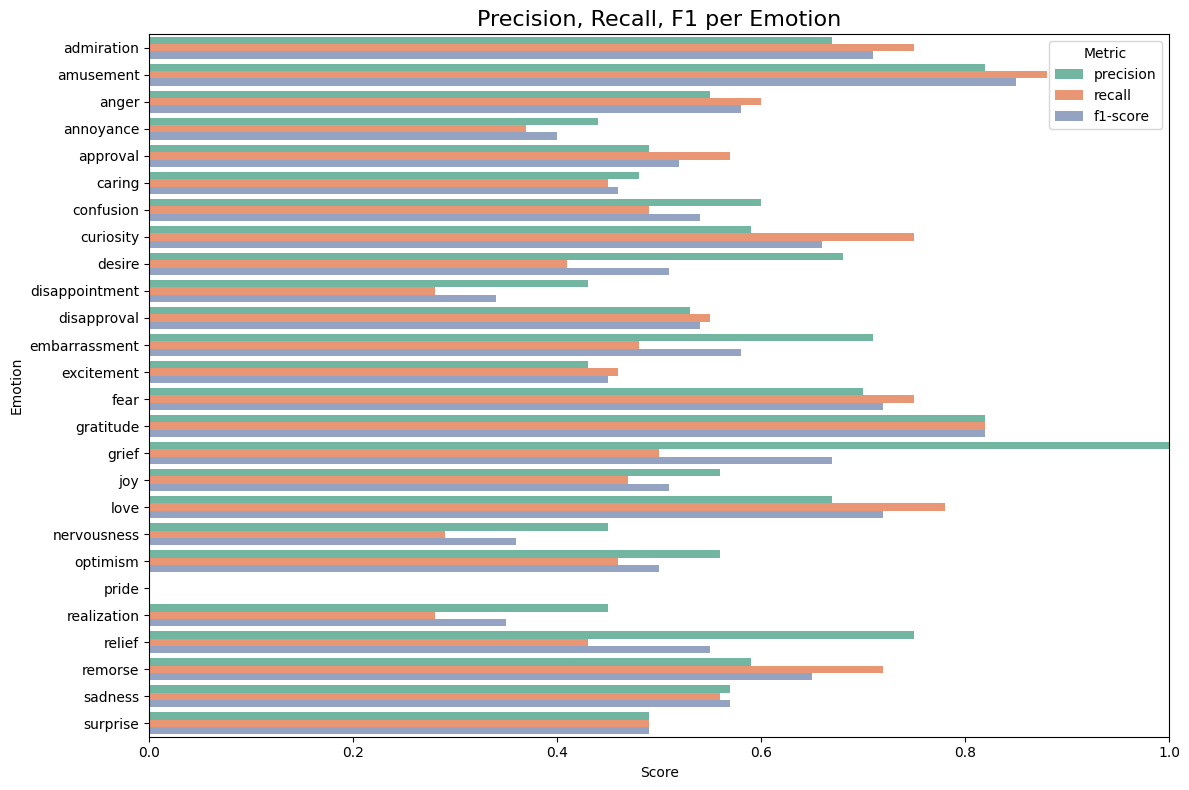

In [34]:
df_melted = df_emotions[["Emotion", "precision", "recall", "f1-score"]].melt(
    id_vars="Emotion", var_name="Metric", value_name="Score"
)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x="Score", y="Emotion", hue="Metric", palette="Set2")
plt.title("Precision, Recall, F1 per Emotion", fontsize=16)
plt.xlabel("Score")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics_per_emotion_subreddit.pdf")
plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics_per_emotion_subreddit.png")
plt.show()

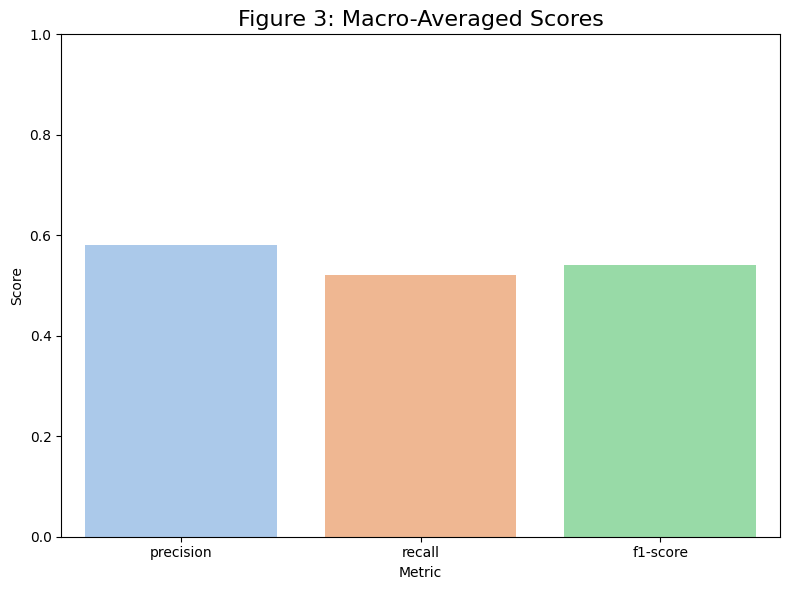

In [35]:
macro_avg = df_report[df_report["Emotion"] == "macro avg"]
macro_df = macro_avg[["precision", "recall", "f1-score"]].melt(
    var_name="Metric", value_name="Score"
)

plt.figure(figsize=(8, 6))
sns.barplot(data=macro_df, x="Metric", y="Score", palette="pastel")
plt.title("Figure 3: Macro-Averaged Scores", fontsize=16)
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/figure_3_macro_avg_score_subreddit.pdf")
plt.savefig(f"{BEST_DIR}/figure_3_macro_avg_scores_subreddit.png")
macro_df.to_csv(f"{BEST_DIR}/figure_3_macro_avg_scores_subreddit.csv", index=False)
plt.show()

In [36]:
df_support = df_emotions[["Emotion", "support"]].sort_values("support", ascending=False)
df_support.to_csv(f"{BEST_DIR}/emotion_support_counts_subreddit.csv", index=False)

In [37]:
cm = confusion_matrix(y_true, y_pred)
conf_df = pd.DataFrame(cm, index=label_names, columns=label_names)
conf_df.to_csv(f"{BEST_DIR}/confusion_matrix_raw_subreddit.csv")

# Top 10 most confused
np.fill_diagonal(cm, 0)
top_confused = sorted(
    [(label_names[i], label_names[j], cm[i, j])
     for i in range(len(cm)) for j in range(len(cm)) if cm[i, j] > 0],
    key=lambda x: -x[2]
)[:10]

print("Top 10 most confused pairs:")
for a, b, count in top_confused:
    print(f"{a} ↔ {b}: {count} times")

Top 10 most confused pairs:
annoyance ↔ anger: 48 times
confusion ↔ curiosity: 41 times
annoyance ↔ disapproval: 36 times
anger ↔ annoyance: 35 times
annoyance ↔ approval: 28 times
admiration ↔ approval: 27 times
approval ↔ admiration: 27 times
gratitude ↔ admiration: 27 times
disapproval ↔ annoyance: 24 times
realization ↔ approval: 24 times
